# Diffusion model

In [89]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.utils import save_image
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, LearningRateMonitor

import pmldiku
from pmldiku import data, model_utils, diffusion, diffusion_utils



%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.diffusion, pmldiku.diffusion_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
torch.manual_seed(1)

cuda = True
batch_size = 128
epochs = 20
device_name = "cuda" if cuda else "cpu"

device = torch.device(device_name)
kwargs = {'num_workers': 4, 'pin_memory': device} 

n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
config = diffusion.ParamConfig(n_steps, min_beta, max_beta)

In [91]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)

loader = data.load_mnist(train=True, trans=transform).setup_data_loader(batch_size=batch_size, **kwargs)

In [92]:
# Construct model from params
model = diffusion.LightningDiffusion(config=config, network = diffusion.UNet, verbose=True)

In [93]:
cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_loss, cb_lr_monitor = (
    ModelCheckpoint(), EarlyStopping('mse_metric'), 
    TQDMProgressBar(), diffusion_utils.DiffusionLossCallback(), LearningRateMonitor('step'))  

callbacks = [cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_loss, cb_lr_monitor]

trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device_name, callbacks=callbacks, auto_lr_find=True)
trainer.fit(model=model, train_dataloaders=loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/pcv439/miniconda3/envs/pml/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name             | Type            | Params
-----------------------------------------------------
0 | diffusion_params | DiffusionParams | 0     
1 | network          | UNet            | 606 K 
2 | diffusion        | Diffusion       | 606 K 
-----------------------------------------------------
506 K     Trainable params
100 K     Non-trainable params
606 K     Total params
2.427     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Setting diffusion params to: cuda:0
training_step_loss 1.0022168159484863
training_step_loss 0.9998584985733032
training_step_loss 0.9970434904098511
training_step_loss 0.9974833726882935
training_step_loss 0.992461621761322
training_step_loss 1.002333641052246
training_step_loss 0.9865131378173828
training_step_loss 0.9831281304359436
training_step_loss 0.9699926376342773
training_step_loss 0.9645442366600037
training_step_loss 0.958230197429657
training_step_loss 0.9460489749908447
training_step_loss 0.9365520477294922
training_step_loss 0.9358709454536438
training_step_loss 0.9149351716041565
training_step_loss 0.8995692729949951
training_step_loss 0.8796827793121338
training_step_loss 0.859619140625
training_step_loss 0.8381745219230652
training_step_loss 0.8183131217956543
training_step_loss 0.796197235584259
training_step_loss 0.7698240876197815
training_step_loss 0.7433381080627441
training_step_loss 0.713013768196106
training_step_loss 0.6751480102539062
training_step_loss 0.63

/scratch/pcv439/miniconda3/envs/pml/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Plot

array([1.00221682, 0.9998585 , 0.99704349, ..., 0.03583964, 0.02510249,
       0.03552161])

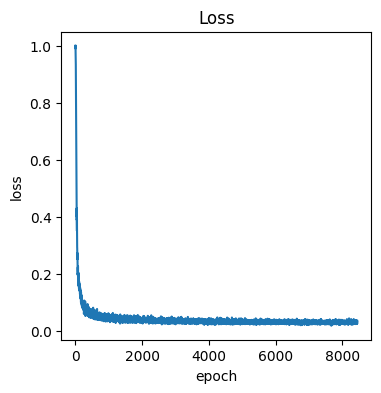

In [75]:
losses = np.array(cb_loss.train_loss)
model_utils.plot_loss(losses)
losses

In [76]:
ims = model.to(device).generate(10)

t = 950
t = 900
t = 850
t = 800
t = 750
t = 700
t = 650
t = 600
t = 550
t = 500
t = 450
t = 400
t = 350
t = 300
t = 250
t = 200
t = 150
t = 100
t = 50
t = 0


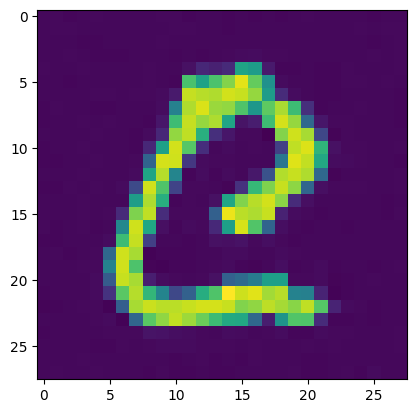

In [79]:
plt.imshow(ims[9].detach().cpu().squeeze().numpy())

In [83]:
best_model = diffusion.LightningDiffusion(config, diffusion.MyUNet).load_from_checkpoint('lightning_logs/version_9/checkpoints/epoch=17-step=8442.ckpt', config=config, network=diffusion.MyUNet)

In [84]:
ims = best_model.to(device).generate(10)



t = 950
t = 900
t = 850
t = 800
t = 750
t = 700
t = 650
t = 600
t = 550
t = 500
t = 450
t = 400
t = 350
t = 300
t = 250
t = 200
t = 150
t = 100
t = 50
t = 0


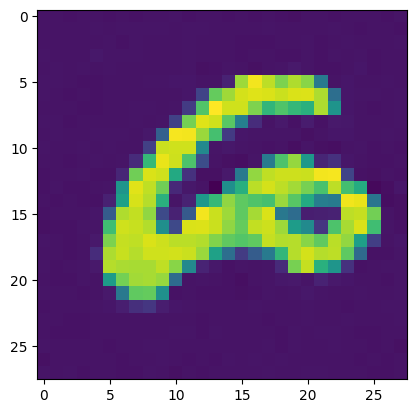

In [88]:
plt.imshow(ims[1].detach().cpu().squeeze().numpy())